In [3]:
visitors_to_A = 1300
visitors_to_B = 1275

conversions_from_A = 120
conversions_from_B = 125

# AとBのコンバージョンの確率のモデリング

* 事前分布はベータ分布
 * 値が0から1まで制限されていて、確率が取る範囲と同じため
* 訪問者とコンバージョンデータは二項分布に従う
 * 1300回中120回の成功とする

* 事前分布が$Beta(\alpha_0,\beta_0)$で$N$回中$X$回の成功を観測
 * 事後分布 => $Beta(\alpha_0 + X,\beta_0 + N - X)$


In [4]:
# scipyのbetaを使えば事後分布からサンプリングできる！

from scipy.stats import beta

# 事前分布をBeta(1,1)と仮定
alpha_prior = 1
beta_prior = 1

posterior_A = beta(alpha_prior + conversions_from_A, beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B, beta_prior + visitors_to_B - conversions_from_B)

In [6]:
# Aの事後分布のサンプルがBの事後分布からのサンプルよりもおおきくなる確率を比較
# rvsメソッドを使ってサンプリング

samples = 20000 #サンプル数を大きくして近似制度を上げたい
samples_posterior_A =  posterior_A.rvs(samples)
samples_posterior_B =  posterior_B.rvs(samples)

print((samples_posterior_A > samples_posterior_B).mean())

0.31105


サイトAがサイトBよりもコンバージョンが高い確率↑

pdfメソッドをつかえば、事後分布を可視化できる

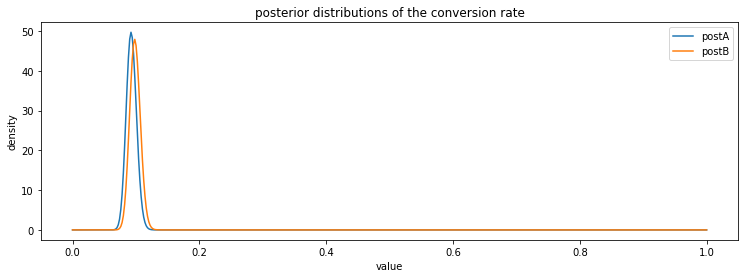

In [9]:
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
figsize(12.5, 4)

x = np.linspace(0, 1, 500)
plt.plot(x, posterior_A.pdf(x), label = 'postA')
plt.plot(x, posterior_B.pdf(x), label = 'postB')

plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distributions of the conversion rate')
plt.legend()

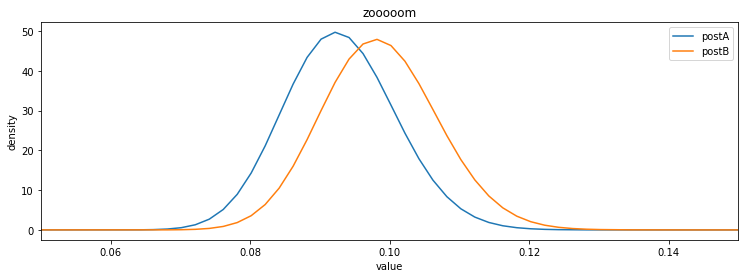

In [11]:
#拡大したもの

plt.plot(x, posterior_A.pdf(x), label = 'postA')
plt.plot(x, posterior_B.pdf(x), label = 'postB')

plt.xlim(0.05, 0.15)
plt.xlabel('value')
plt.ylabel('density')
plt.title('zooooom')
plt.legend()

選択肢は成功か失敗家の場合は解析は単純
では選択が複数ある場合で、それによってビジネスに影響がある場合はどうなるか

# 線形損失関数の追加

## 契約プランを最適化
ユーザーに契約プランページを2通り提示し、1回あたりの期待収益を決定することを考える。

## 期待収益の解析
1つの契約プランの解析。

契約プランの期待値

$E[R] = 79p_{79} + 49p_{49} + 25p_{25}+ 0p_0$

$ p_{79} $は79ドルのプランを選択する確率。他も同様。
それゆえ  
$p_{79} + p_{49} + p_{25} + p_0 = 1$

### 確率を推定する
個々の確率は独立ではなく足して1なのでベータ分布、二項分布は使えない。

#### 多項分布
二項分布を一般化したものが多項分布

In [16]:
from numpy.random import multinomial
P = [0.5, 0.2, 0.3]
N = 1
print(multinomial(N, P))

[0 1 0]


In [20]:
N = 10
print(multinomial(N, P))

[4 3 3]


#### ディリクレ分布
- ベータ分布を一般化したものがディリクレ分布
- 足して1になる正のベクトルを返す
- 出力ベクトルの長さは入力ベクトルの長さで変わる

In [22]:
from numpy.random import dirichlet
sample = dirichlet([1,1])
print(sample)
print(sample.sum())

[ 0.4362013  0.5637987]
1.0


In [23]:
sample = dirichlet([1,1,1,1])
print(sample)
print(sample.sum())

[ 0.45209898  0.29438651  0.19634602  0.05716849]
1.0


ディリクレ分布と多項分布の関係は、ベータ分布と二項分布の関係に似ている。
つまり、求めたい確率の事後分布を数式で表せるということ。

- 事前分布: $Dirichlet(1,1,1..1)$
- 観測: N_1,N_2,,,,N_m

とすると事後分布

$Dirichlet(1 + N_1,1 + N_2,..1 + N_m)$

事後分布からのサンプルは足して1になる

### いくつかサンプルをためす

In [25]:
# 1000人の訪問者がいる
N = 1000
N_79 = 10
N_49 = 46
N_25 = 80
N_0 = N - N_79 - N_49 - N_25

observations = np.array([N_79, N_49, N_25, N_0])

prior_parameters = np.array([1,1,1,1])
posterior_samples = dirichlet(prior_parameters + observations, size=10000)

print("two random samples from the posterir")
print(posterior_samples[0])
print(posterior_samples[1])

two random samples from the posterir
[ 0.01296796  0.05249245  0.08064445  0.85389514]
[ 0.00843284  0.04580282  0.08302515  0.8627392 ]


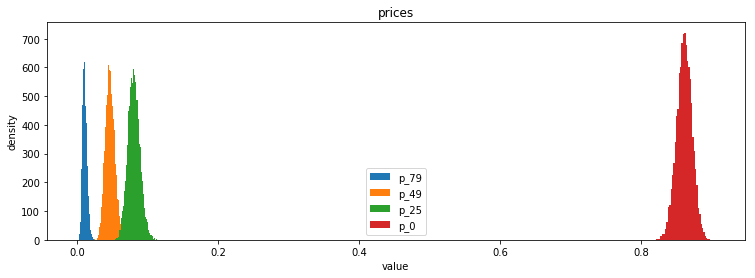

In [26]:
# この事後分布の確率密度関数をプロット

for i, label in enumerate(['p_79','p_49', 'p_25','p_0']):
    plt.hist(posterior_samples[:,i], bins = 50,label = label, histtype='stepfilled')

plt.xlabel('value')
plt.ylabel('density')
plt.title('prices')
plt.legend()

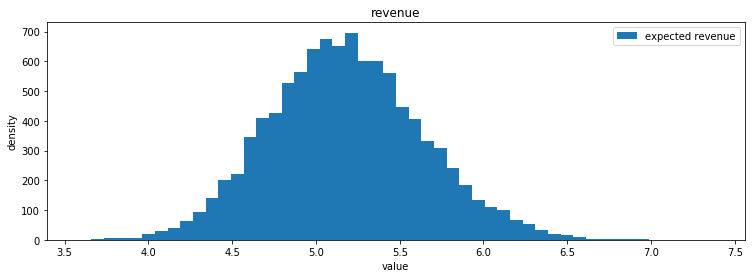

In [27]:
# 期待収益のの事後分布を求める

def expected_revenue(P):
    return 79 * P[:, 0] + 49 * P[:, 1] + 25 * P[:,2] + 0 * P[:,3]

posterior_expected_revenue = expected_revenue(posterior_samples)
plt.hist(posterior_expected_revenue, histtype = 'stepfilled', bins = 50, label = 'expected revenue')

plt.xlabel('value')
plt.ylabel('density')
plt.title('revenue')
plt.legend()

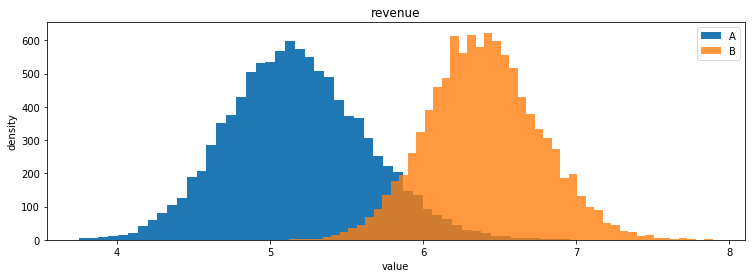

In [32]:
# ABテストへ拡張
# ページAとBの解析をする
# 以下のデータを用意

N_A = 1000
N_A_79 = 10
N_A_49 = 46
N_A_25 = 80
N_A_0 = N_A - N_A_79 - N_A_49 - N_A_25
observations_A = np.array([N_A_79, N_A_49, N_A_25, N_A_0])

N_B = 2000
N_B_79 = 45
N_B_49 = 84
N_B_25 = 200
N_B_0 = N_B - N_B_79 - N_B_49 - N_B_25
observations_B = np.array([N_B_79, N_B_49, N_B_25, N_B_0])


prior_parameters = np.array([1,1,1,1])

posterior_samples_A = dirichlet(prior_parameters + observations_A, size=10000)
posterior_samples_B = dirichlet(prior_parameters + observations_B, size=10000)

# 期待収益のの事後分布を求める
posterior_expected_revenue_A = expected_revenue(posterior_samples_A)
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

plt.hist(posterior_expected_revenue_A, histtype = 'stepfilled', bins = 50, label = 'A')
plt.hist(posterior_expected_revenue_B, histtype = 'stepfilled', bins = 50, label = 'B', alpha=0.8)

plt.xlabel('value')
plt.ylabel('density')
plt.title('revenue')
plt.legend()

- AはBより期待収益が1ドル少ない
- 訪問者ベースなので、結構でかい

In [31]:
# 差異が存在することを確かめる
# BがAより収益が大きい確率

p = (posterior_expected_revenue_B > posterior_expected_revenue_A).mean()
print('probability that page B has a higher revenue than page A: %.3f' %p)

probability that page B has a higher revenue than page A: 0.981


十分おおきいのでBを採用すべき

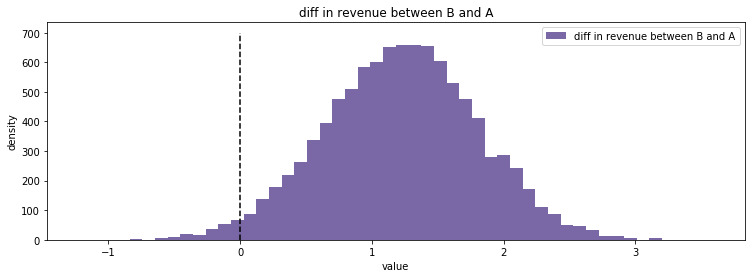

In [35]:
# 収益の差の事後分布を表示

posterior_diff = posterior_expected_revenue_B - posterior_expected_revenue_A
plt.hist(posterior_diff, histtype = 'stepfilled', color='#7A68A6', bins = 50, label = 'diff in revenue between B and A')
plt.vlines(0,0,700,linestyles='--')
plt.xlabel('value')
plt.ylabel('density')
plt.title('diff in revenue between B and A')
plt.legend()

Bを採用するという結論が間違っていても、損失は-0.5ドルぐらいですむ？

In [36]:
N = 250
mu_A , std_A = 30, 4
mu_B , std_B = 26, 7

# ユーザーのペーじ時滞在時間(秒)の作成
durations_A = np.random.normal(mu_A, std_A, size=N)
durations_B = np.random.normal(mu_B, std_B, size=N)

print(durations_A[:8])
print(durations_B[:8])

[ 30.57305455  28.57913276  31.38846183  29.72441154  27.65721829
  31.16344958  28.20569906  36.21294793]
[ 29.99144667  31.23375803  32.78020767  27.81806076  26.4953133
  25.13121158  33.00739198  16.86721334]


In [38]:
import pymc as pm

pooled_mean = np.r_[durations_A, durations_B].mean()
pooled_std = np.r_[durations_A, durations_B].std()

# PYMCでは標準偏差ではなく精度を使う
tau = 1. / np.sqrt(1000. * pooled_std)

mu_A = pm.Normal("mu_A", pooled_mean, tau)
mu_B = pm.Normal("mu_B", pooled_mean, tau)

In [39]:
std_A = pm.Uniform("std_A", pooled_std / 1000., 1000. * pooled_std)
std_B = pm.Uniform("std_B", pooled_std / 1000., 1000. * pooled_std)

In [40]:
nu_minus_1 = pm.Exponential("nu-1", 1. / 29)

In [43]:
obs_A = pm.NoncentralT("obs_A", mu_A, 1.0 / std_A ** 2, nu_minus_1 + 1, observed = True, value=durations_A)
obs_B = pm.NoncentralT("obs_B", mu_B, 1.0 / std_B ** 2, nu_minus_1 + 1, observed = True, value=durations_B)
mcmc = pm.MCMC([obs_A, obs_B, mu_A, mu_B, std_A, std_B, nu_minus_1])
mcmc.sample(25000, 10000)

 [-----------------100%-----------------] 25000 of 25000 complete in 22.8 sec

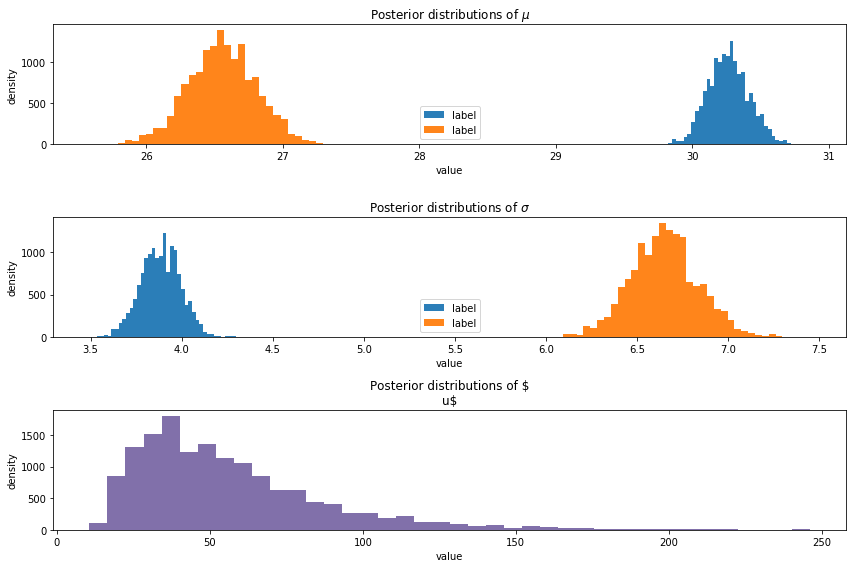

In [45]:
mu_A_trace = mcmc.trace('mu_A')[:]
mu_B_trace = mcmc.trace('mu_B')[:]
std_A_trace = mcmc.trace('std_A')[:]
std_B_trace = mcmc.trace('std_B')[:]
nu_trace = mcmc.trace("nu-1")[:] + 1

figsize(12, 8)

def _hist(data, label, **kwargs):
    return plt.hist(data, bins = 40, histtype='stepfilled', alpha= .95, label="label", **kwargs)

ax = plt.subplot(3,1,1)
_hist(mu_A_trace, 'A')
_hist(mu_B_trace, 'B')
plt.xlabel('value')
plt.ylabel('density')
plt.title('Posterior distributions of $\mu$') #muの事後分布
plt.legend()

ax = plt.subplot(3,1,2)
_hist(std_A_trace, 'A')
_hist(std_B_trace, 'B')
plt.xlabel('value')
plt.ylabel('density')
plt.title('Posterior distributions of $\sigma$') # sigmaの事後分布
plt.legend()

ax = plt.subplot(3,1,3)
_hist(nu_trace, '', color='#7A68A6')
plt.xlabel('value')
plt.ylabel('density')
plt.title('Posterior distributions of $\nu$') # nuの事後分布
plt.tight_layout()

In [ ]:
$p_A - $

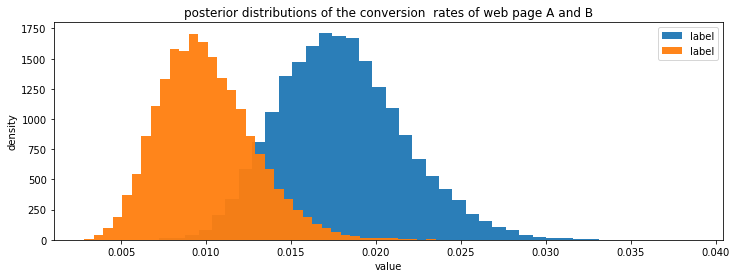

In [46]:
figsize(12, 4)

visitors_to_A = 1275
visitors_to_B = 1300

conversions_from_A = 22
conversions_from_B = 12

alpha_prior = 1
beta_prior = 1

posterior_A = beta(alpha_prior + conversions_from_A, beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B, beta_prior + visitors_to_B - conversions_from_B)

samples = 20000 
samples_posterior_A =  posterior_A.rvs(samples)
samples_posterior_B =  posterior_B.rvs(samples)

_hist(samples_posterior_A, 'A')
_hist(samples_posterior_B, 'B')
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distributions of the conversion  rates of web page A and B')
plt.legend()

(array([  4.20000000e+01,   2.45000000e+02,   8.76000000e+02,
          1.54300000e+03,   2.26100000e+03,   2.46400000e+03,
          2.55400000e+03,   2.22900000e+03,   1.91200000e+03,
          1.43500000e+03,   1.12300000e+03,   8.96000000e+02,
          6.76000000e+02,   4.58000000e+02,   3.73000000e+02,
          2.58000000e+02,   1.67000000e+02,   1.17000000e+02,
          1.03000000e+02,   5.90000000e+01,   5.90000000e+01,
          3.00000000e+01,   3.30000000e+01,   2.50000000e+01,
          1.70000000e+01,   1.10000000e+01,   6.00000000e+00,
          7.00000000e+00,   4.00000000e+00,   3.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([-0.50255161, -0.31386909, -0.12518657,  0.06349595,  0.25217848,
         0.440861  ,  0.62954352,  0.81822604,  1.00690857,  1.19559109,
         1.38427361,

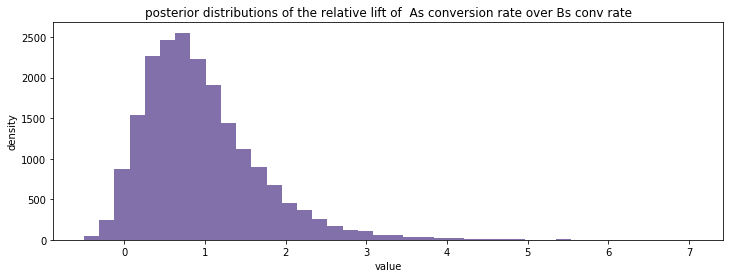

In [47]:
def relative_increase(a, b):
    return (a-b)/ b

posterior_rel_increase = relative_increase(samples_posterior_A, samples_posterior_B)
plt.xlabel('value')
plt.ylabel('density')
plt.title('posterior distributions of the relative lift of  As conversion rate over Bs conv rate')
_hist(posterior_rel_increase, 'relative increase', color='#7A68A6')

In [48]:
print((posterior_rel_increase > 0.2).mean())
print((posterior_rel_increase > 0.5).mean())

0.88935
0.71355


$p_A = 22/1275 = 0.017$  
$p_B = 12/1300 = 0.009$

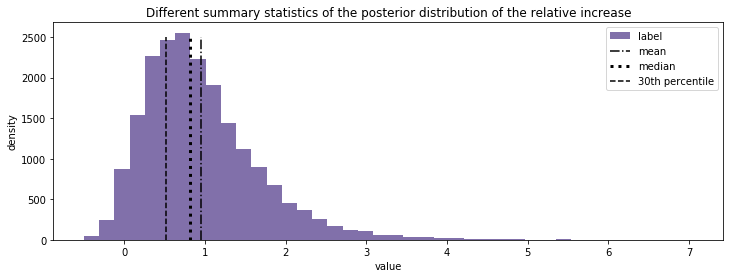

In [50]:
mean = posterior_rel_increase.mean()
median = np.percentile(posterior_rel_increase, 50)
conservative_percentile = np.percentile(posterior_rel_increase, 30)

_hist(posterior_rel_increase, '', color='#7A68A6')

plt.vlines(mean, 0, 2500, linestyles='-.', label='mean') #平均
plt.vlines(median, 0, 2500, linestyles=':', label='median', lw=3) #中央値
plt.vlines(conservative_percentile, 0, 2500, linestyles='--', label='30th percentile') #30パーセンタイル
plt.xlabel('value')
plt.ylabel('density')
plt.title('Different summary statistics of the posterior distribution of the relative increase')
plt.legend()